In [451]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
%matplotlib inline

In [2]:
hr = pd.read_excel('WA_Fn-UseC_-HR-Employee-Attrition.xlsx', 
                   sheet_name = 'WA_Fn-UseC_-HR-Employee-Attriti')

In [3]:
hr.shape

(1470, 35)

In [4]:
print('Over18: ', hr.Over18.unique())
print('EmployeeCount: ', hr.EmployeeCount.unique())
print('StandardHours: ', hr.StandardHours.unique())
print('EmployeeNumber: ', len(hr.EmployeeNumber))

Over18:  ['Y']
EmployeeCount:  [1]
StandardHours:  [80]
EmployeeNumber:  1470


In [5]:
hr = hr.drop(['Over18', 'EmployeeCount', 'StandardHours', 'EmployeeNumber'],
            axis = 1)

In [6]:
hr.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [7]:
numerics=['float64', 'int64']
objects=hr.select_dtypes(exclude=numerics)

In [8]:
objects.describe().T

,count,unique,top,freq
Attrition,1470,2,No,1233
BusinessTravel,1470,3,Travel_Rarely,1043
Department,1470,3,Research & Development,961
EducationField,1470,6,Life Sciences,606
Gender,1470,2,Male,882
JobRole,1470,9,Sales Executive,326
MaritalStatus,1470,3,Married,673
OverTime,1470,2,No,1054


In [9]:
print(hr.groupby('Attrition').size())

Attrition
No     1233
Yes     237
dtype: int64


#### This is an unbalance data set: attrition rate almost equals to 1:5
* Because of the imbalance, the performance metric used in this project is AUC. Also, tree based algorithms often performance well on imbalanced datasets because their hierarchical structure allows them to learn signals from both classes. So, in this project, I try to use tree based algorithms (e.g. decision tree, random forest and gradient boosting) to create classifiers to predict employee attrition.
* PS: AUROC (Area under ROC Curve): representing the likelihood of the model distinguishing observations from two classes.

In [10]:
hr.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.0,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.0,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.0,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.0,3.0,4.00,5.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.0,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.0,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.0,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.0,2.0,3.00,5.0
JobSatisfaction,1470.0,2.728571,1.102846,1.0,2.0,3.0,4.00,4.0
MonthlyIncome,1470.0,6502.931293,4707.956783,1009.0,2911.0,4919.0,8379.00,19999.0


## 1. Define functions for some repeated stepts：

In [80]:
def model(model, trainx, trainy, testx, testy):
    model = model.fit(trainx, trainy)
    predict = model.predict(testx)
    
    fpr_train, tpr_train,_=roc_curve(trainy, model.predict(trainx))
    auc_train=auc(fpr_train, tpr_train)
    
    fpr_test, tpr_test,_=roc_curve(testy, predict)
    auc_test=auc(fpr_test, tpr_test)
    
    print('AUC(Train): {:.4f}'.format(auc_train))
    print('AUC(Test):  {:.4f}'.format(auc_test))
    
    cm = confusion_matrix(testy, predict, labels = [0, 1])
    print('Confusion matrix, without normalization:')
    print(cm)
    print("Normalized confusion matrix:")
    print(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
    print(classification_report(testy,predict))

In [63]:
def label(df, column_name):
    le = LabelEncoder()
    print(column_name, ':')
    print(list(df[column_name].unique()))
    values = list(df[column_name].unique())
    x[column_name] = le.fit(list(df[column_name].unique())).transform(df[column_name])
    print(list(df[column_name].unique()))
    keys = list(df[column_name].unique())
    dictionary = dict(zip(keys, values))
    return x[column_name], dictionary

In [64]:
def gridSearch(parameters, model, x, y):
    gridsearch = GridSearchCV(model, parameters, scoring = 'roc_auc', cv = 3)
    gridsearch.fit(x, y)
    
    print("Best parameters: {}".format(gridsearch.best_params_))
    print("Best cross-validation AUC: {:.4f}".format(gridsearch.best_score_))
    print(gridsearch.best_estimator_)

In [65]:
def gridSearch2(parameters, model, x, y):
    gridsearch = GridSearchCV(model, parameters, scoring = 'recall', cv = 3)
    gridsearch.fit(x, y)
    
    print("Best parameters: {}".format(gridsearch.best_params_))
    print("Best cross-validation Recall: {:.4f}".format(gridsearch.best_score_))
    print(gridsearch.best_estimator_)

In [66]:
def feature_importance_chart(model):
    feat_imp = pd.Series(model.feature_importances_, xtrain.columns).sort_values(ascending=False)
    plt.figure(figsize=(15,8))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return pd.DataFrame({'Column':xtrain.columns, 'Feature Importances':model.feature_importances_}).sort_values(by='Feature Importances', ascending = False).set_index('Column')

In [395]:
def DensityPlots(column):
    subset = hr[hr['Attrition'] == 'Yes']
    subset2 = hr[hr['Attrition'] != 'Yes']
    sns.distplot(subset[column], hist = False, label = 'Yes')
    sns.distplot(subset2[column], hist = False, label = 'No')
    plt.grid()

## 2. Create the datasets

In [67]:
y = hr['Attrition'].map(lambda x: 1 if x == 'Yes' else 0)
x = hr.drop(['Attrition'], axis = 1)

### Label encoder

In [68]:
x['BusinessTravel'], BusinessTravel = label(x, 'BusinessTravel')

BusinessTravel :
['Travel_Rarely', 'Travel_Frequently', 'Non-Travel']
[2, 1, 0]


In [69]:
x['Department'], Department = label(x, 'Department')

Department :
['Sales', 'Research & Development', 'Human Resources']
[2, 1, 0]


In [70]:
x['EducationField'], EducationField = label(x, 'EducationField')

EducationField :
['Life Sciences', 'Other', 'Medical', 'Marketing', 'Technical Degree', 'Human Resources']
[1, 4, 3, 2, 5, 0]


In [71]:
x['Gender'], Gender = label(x, 'Gender')

Gender :
['Female', 'Male']
[0, 1]


In [72]:
x['JobRole'], JobRole = label(x, 'JobRole')

JobRole :
['Sales Executive', 'Research Scientist', 'Laboratory Technician', 'Manufacturing Director', 'Healthcare Representative', 'Manager', 'Sales Representative', 'Research Director', 'Human Resources']
[7, 6, 2, 4, 0, 3, 8, 5, 1]


In [73]:
x['MaritalStatus'], MaritalStatus = label(x, 'MaritalStatus')

MaritalStatus :
['Single', 'Married', 'Divorced']
[2, 1, 0]


In [74]:
x['OverTime'], OverTime = label(x, 'OverTime')

OverTime :
['Yes', 'No']
[1, 0]


### train test split

In [77]:
xtrain, xtest, ytrain,ytest=train_test_split(x, y, 
                                             random_state=666, test_size=0.2)

In [78]:
print("The shape of xtrain is: ", xtrain.shape)
print("The shape of ytrain is: ", ytrain.shape)
print("The shape of xtest is: ", xtest.shape)
print("The shape of ytest is: ", ytest.shape)

The shape of xtrain is:  (1176, 30)
The shape of ytrain is:  (1176,)
The shape of xtest is:  (294, 30)
The shape of ytest is:  (294,)


* In this project, I used decision tree, random forest and gradient boosting, which are all tree based algorithm, to predict the employee attrition.

## 3. Create model

## (1) Decision Tree:

In [81]:
model(DecisionTreeClassifier(), xtrain, ytrain, xtest, ytest)

AUC(Train): 1.0000
AUC(Test):  0.5794
Confusion matrix, without normalization:
[[220  32]
 [ 30  12]]
Normalized confusion matrix:
[[0.87301587 0.12698413]
 [0.71428571 0.28571429]]
             precision    recall  f1-score   support

          0       0.88      0.87      0.88       252
          1       0.27      0.29      0.28        42

avg / total       0.79      0.79      0.79       294



* The model is overfit because auc is 1 when applying model on train dataset;
* The model is just better than randomly gussing when applied on test dataset.

### Decision Tree Pre-pruning:

In [82]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

tree_param={"max_depth":max_depths,
          'min_samples_split':min_samples_splits}

#### set roc_auc as the threshold of gridsearch:

In [27]:
gridSearch(tree_param, DecisionTreeClassifier(), xtrain, ytrain)

Best parameters: {'max_depth': 3.0, 'min_samples_split': 0.1}
Best cross-validation AUC: 0.7115
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3.0,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [84]:
model(DecisionTreeClassifier(max_depth = 3.0, min_samples_split = 0.1), xtrain, ytrain, xtest, ytest)

AUC(Train): 0.5934
AUC(Test):  0.5893
Confusion matrix, without normalization:
[[249   3]
 [ 34   8]]
Normalized confusion matrix:
[[0.98809524 0.01190476]
 [0.80952381 0.19047619]]
             precision    recall  f1-score   support

          0       0.88      0.99      0.93       252
          1       0.73      0.19      0.30        42

avg / total       0.86      0.87      0.84       294



#### set recall as the threshold of gridsearch:

In [83]:
gridSearch2(tree_param, DecisionTreeClassifier(), xtrain, ytrain)

Best parameters: {'max_depth': 3.0, 'min_samples_split': 0.2}
Best cross-validation Recall: 0.1897
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3.0,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [85]:
model(DecisionTreeClassifier(max_depth = 3.0, min_samples_split = 0.2), xtrain, ytrain, xtest, ytest)

AUC(Train): 0.6366
AUC(Test):  0.6448
Confusion matrix, without normalization:
[[241  11]
 [ 28  14]]
Normalized confusion matrix:
[[0.95634921 0.04365079]
 [0.66666667 0.33333333]]
             precision    recall  f1-score   support

          0       0.90      0.96      0.93       252
          1       0.56      0.33      0.42        42

avg / total       0.85      0.87      0.85       294



* The AUC for applying the model to train dataset decreases which means the overfitting problem is relieved.
* Looks like setting recall as the threshold of grid search is better, coz is more important because most HR groups would probably prefer to incorrectly classify folks not looking to quit as high potential of quiting rather than classify those that are likely to quit as not at risk.

## (2) Random Forest

In [86]:
model(RandomForestClassifier(random_state = 10), xtrain, ytrain, xtest, ytest)

AUC(Train): 0.9769
AUC(Test):  0.5575
Confusion matrix, without normalization:
[[245   7]
 [ 36   6]]
Normalized confusion matrix:
[[0.97222222 0.02777778]
 [0.85714286 0.14285714]]
             precision    recall  f1-score   support

          0       0.87      0.97      0.92       252
          1       0.46      0.14      0.22        42

avg / total       0.81      0.85      0.82       294



### Fine-tuning parameters

In [93]:
randomforest_param={"n_estimators": list(range(50, 131, 10)),
           "max_depth":[5, 10,15,20]}

In [94]:
gridSearch2(randomforest_param, RandomForestClassifier(random_state = 10), xtrain, ytrain)

Best parameters: {'max_depth': 10, 'n_estimators': 130}
Best cross-validation Recall: 0.1949
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=130, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)


In [95]:
model(RandomForestClassifier(random_state = 10, max_depth = 10, n_estimators = 130), xtrain, ytrain, xtest, ytest)

AUC(Train): 0.9385
AUC(Test):  0.5754
Confusion matrix, without normalization:
[[248   4]
 [ 35   7]]
Normalized confusion matrix:
[[0.98412698 0.01587302]
 [0.83333333 0.16666667]]
             precision    recall  f1-score   support

          0       0.88      0.98      0.93       252
          1       0.64      0.17      0.26        42

avg / total       0.84      0.87      0.83       294



## (3) Gradent Boosting Classifier 

In [97]:
model(GradientBoostingClassifier(random_state = 10), xtrain, ytrain, xtest, ytest)

AUC(Train): 0.8738
AUC(Test):  0.6687
Confusion matrix, without normalization:
[[247   5]
 [ 27  15]]
Normalized confusion matrix:
[[0.98015873 0.01984127]
 [0.64285714 0.35714286]]
             precision    recall  f1-score   support

          0       0.90      0.98      0.94       252
          1       0.75      0.36      0.48        42

avg / total       0.88      0.89      0.87       294



### Fine-tuning parameters

In [98]:
GBM_param={"learning_rate":[0.01, 0.1, 0.2, 0.3],
           "n_estimators":[50, 60, 70, 80, 100],
           "max_depth":[3, 5, 7]}

In [99]:
gridSearch2(GBM_param, GradientBoostingClassifier(random_state = 10), xtrain, ytrain)

Best parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100}
Best cross-validation Recall: 0.3436
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False)


In [100]:
model(GradientBoostingClassifier(random_state = 10, learning_rate = 0.3, max_depth = 3, n_estimators = 100),
      xtrain, ytrain, xtest, ytest)

AUC(Train): 0.9897
AUC(Test):  0.6409
Confusion matrix, without normalization:
[[239  13]
 [ 28  14]]
Normalized confusion matrix:
[[0.9484127  0.0515873 ]
 [0.66666667 0.33333333]]
             precision    recall  f1-score   support

          0       0.90      0.95      0.92       252
          1       0.52      0.33      0.41        42

avg / total       0.84      0.86      0.85       294



#### Among the  above three models, gradient boosting get the best AUC but the outcome is obviousely not good enough (auc only equals to 0.6. What I need is auc equals to or larger than 0.75). Luckly, in the data exploration step, I found the dataset is imbalance, which means I can try some methods to tackle the data imbalance to improve the performance of the model.
### The methods I want to test are:
* Down-sampling;
* Up-sampling;
* SMOTE.



## 4. Gradient Boosting with down-sampling, up-sampling and SMOTE

In [102]:
train = pd.concat([xtrain, ytrain], axis=1)

minority = train[train.Attrition == 1]
majority = train[train.Attrition == 0]

print(majority.shape)
print(minority.shape)

(981, 31)
(195, 31)


## Down-sampling

In [103]:
# Down-sampling the minority class
majority_downsample = resample(majority, replace = False,
                             n_samples = 195, random_state = 123)

In [104]:
# Combining majority class with down-sampled minority calss
train_downsampled = pd.concat([minority, majority_downsample], axis =0)
print(train_downsampled.shape)
print(train_downsampled.Attrition.value_counts())

(390, 31)
1    195
0    195
Name: Attrition, dtype: int64


In [105]:
ytrain_downsampled = train_downsampled.Attrition
xtrain_downsampled = train_downsampled.drop('Attrition', axis = 1)
print(xtrain_downsampled.shape)
print(ytrain_downsampled.shape)

(390, 30)
(390,)


In [106]:
model(GradientBoostingClassifier(random_state = 10), 
      xtrain_downsampled, ytrain_downsampled, xtest, ytest)

AUC(Train): 0.9769
AUC(Test):  0.7718
Confusion matrix, without normalization:
[[191  61]
 [  9  33]]
Normalized confusion matrix:
[[0.75793651 0.24206349]
 [0.21428571 0.78571429]]
             precision    recall  f1-score   support

          0       0.95      0.76      0.85       252
          1       0.35      0.79      0.49        42

avg / total       0.87      0.76      0.79       294



## Up-sampling

In [108]:
# Up-sampling the minority class
minority_upsample = resample(minority, replace = True,
                             n_samples = 981, random_state = 123)

In [109]:
# Combining majority class with up-sampled minority calss
train_upsampled = pd.concat([minority_upsample, majority], axis =0)
print(train_upsampled.shape)
print(train_upsampled.Attrition.value_counts())

(1962, 31)
1    981
0    981
Name: Attrition, dtype: int64


In [110]:
ytrain_upsampled = train_upsampled.Attrition
xtrain_upsampled = train_upsampled.drop('Attrition', axis = 1)
print(xtrain_upsampled.shape)
print(ytrain_upsampled.shape)

(1962, 30)
(1962,)


In [139]:
model(GradientBoostingClassifier(random_state = 10), 
      xtrain_upsampled, ytrain_upsampled, xtest, ytest)

AUC(Train): 0.9470
AUC(Test):  0.7540
Confusion matrix, without normalization:
[[224  28]
 [ 16  26]]
Normalized confusion matrix:
[[0.88888889 0.11111111]
 [0.38095238 0.61904762]]
             precision    recall  f1-score   support

          0       0.93      0.89      0.91       252
          1       0.48      0.62      0.54        42

avg / total       0.87      0.85      0.86       294



## SMOTE

In [112]:
smote = SMOTE(ratio='minority', random_state=0)
xtrain_smote, ytrain_smote = smote.fit_sample(xtrain, ytrain)
print(xtrain.shape)
print(ytrain.shape)
print(xtrain_smote.shape)
print(ytrain_smote.shape)

(1176, 30)
(1176,)
(1962, 30)
(1962,)


In [113]:
minority2 = ytrain_smote[ytrain_smote == 1]
majority2 = ytrain_smote[ytrain_smote == 0]

print(majority2.shape)
print(minority2.shape)

(981,)
(981,)


In [114]:
model(GradientBoostingClassifier(random_state = 10), xtrain_smote, ytrain_smote, xtest, ytest)

AUC(Train): 0.9659
AUC(Test):  0.6825
Confusion matrix, without normalization:
[[242  10]
 [ 25  17]]
Normalized confusion matrix:
[[0.96031746 0.03968254]
 [0.5952381  0.4047619 ]]
             precision    recall  f1-score   support

          0       0.91      0.96      0.93       252
          1       0.63      0.40      0.49        42

avg / total       0.87      0.88      0.87       294



### Comparing the 3 resampling methods

Among the above three resampling methods, up-sampling gets the best AUC score(0.7540).

#### Adjusting the threshold to 0.40(default)

In [224]:
gb_test_model2 = GradientBoostingClassifier(random_state=10).fit(xtrain_upsampled, ytrain_upsampled)
predict_test2 = gb_test_model2.predict(xtest)
probability_test2 = gb_test_model2.predict_proba(xtest)[:,1]


test_pre2 = pd.DataFrame({'Attrition':list(ytest),
              'Predicted Attrition':list(predict_test2), 
              'Propability':list(probability_test2)})

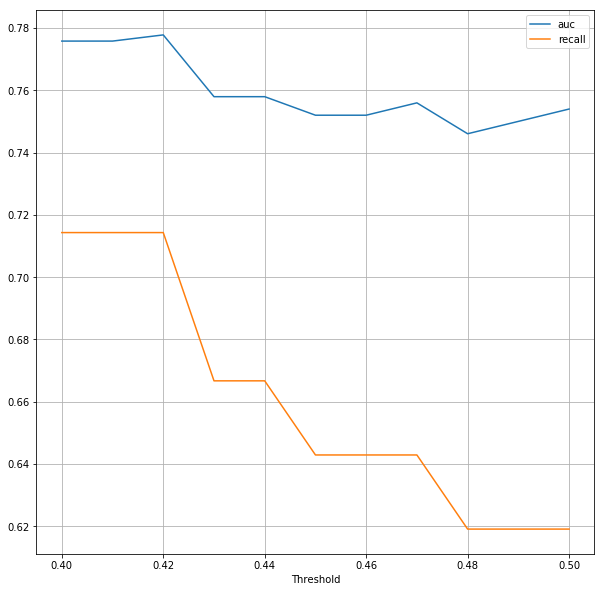

In [325]:
i = 0.40
recall_list = []
auc_list = []
threshold_list = []
while i <= 0.51:
    a=round(i, 2)
    threshold_list.append(a)
    test_pre2['new']=test_pre2['Propability'].map(lambda x: 1 if x > a else 0)
    recall = recall_score(ytest,test_pre2['new'])
    recall_list.append(recall)
    fpr_test, tpr_test,_=roc_curve(ytest,test_pre2['new'])
    auc_test=auc(fpr_test, tpr_test)
    auc_list.append(auc_test)
    i=i+0.01
    
thre = pd.DataFrame({'Threshold':threshold_list,
              'recall':recall_list, 
              'auc':auc_list})

fig, ax =plt.subplots(figsize=(10,10))

ax.plot('Threshold', 'auc', label='auc',data=thre)
ax.plot('Threshold', 'recall', label='recall',data=thre)
ax.set_xlabel('Threshold')
ax.grid(True)
ax.legend()

In [327]:
print(classification_report(ytest,test_pre2['Predicted Attrition']))
fpr_test, tpr_test,_=roc_curve(ytest,test_pre2['Predicted Attrition'])
auc_test=auc(fpr_test, tpr_test)
print('AUC(Test):  {:.4f}'.format(auc_test))

             precision    recall  f1-score   support

          0       0.93      0.89      0.91       252
          1       0.48      0.62      0.54        42

avg / total       0.87      0.85      0.86       294

AUC(Test):  0.7540


In [328]:
# test_pre2[(test_pre2['Attrition']==1)&((test_pre2['Predicted Attrition']==0))]

In [331]:
test_pre2['new']=test_pre2['Propability'].map(lambda x: 1 if x > 0.40 else 0)
print(classification_report(ytest,test_pre2['new']))
print('Recall: {:.4f}'.format(recall_score(ytest,test_pre2['new'])))
fpr_test, tpr_test,_=roc_curve(ytest,test_pre2['new'])
auc_test=auc(fpr_test, tpr_test)
print('AUC(Test):  {:.4f}'.format(auc_test))

             precision    recall  f1-score   support

          0       0.95      0.84      0.89       252
          1       0.43      0.71      0.54        42

avg / total       0.87      0.82      0.84       294

Recall: 0.7143
AUC(Test):  0.7778


#### Feature Inportance

,Feature Importances
Column,
MonthlyIncome,0.142632
DailyRate,0.094755
Age,0.079006
MonthlyRate,0.072843
HourlyRate,0.052621
DistanceFromHome,0.040713
JobRole,0.039755
TotalWorkingYears,0.036374
PercentSalaryHike,0.034500


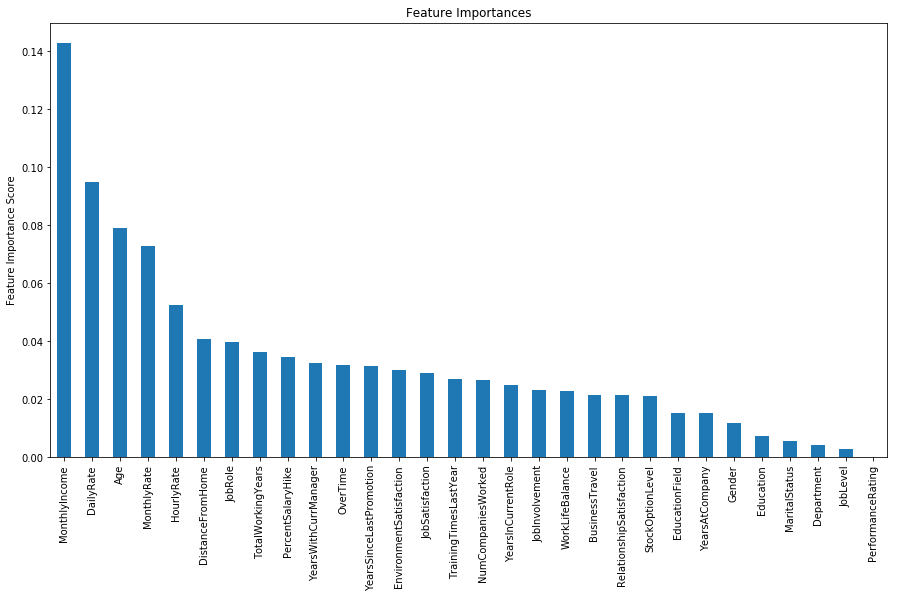

In [234]:
feature_importance_chart(gb_test2)[:10]

In [271]:
hr['Attrition_numeric'] = hr.Attrition.map(lambda x: 1 if x=='Yes' else 0)

In [276]:
# hr.corr().iloc[-1].sort_values().iloc[:23]

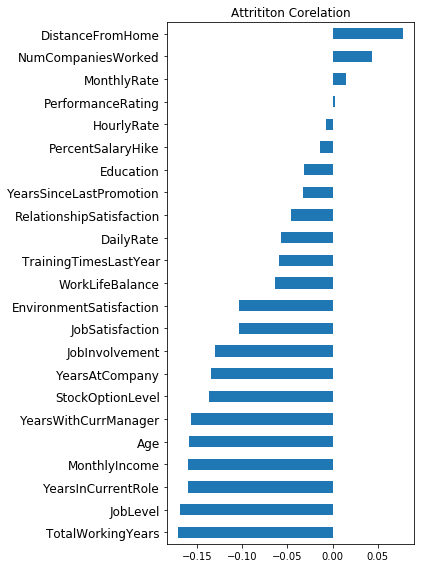

In [275]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
ax = hr.corr().iloc[-1].sort_values().iloc[:23].plot(kind="barh", figsize=(6, 8), ax=ax)
ax.tick_params(axis='y', which='major', labelsize=12)
ax.set_title("Attrititon Corelation")
plt.tight_layout()

## Visualization

#### MonthlyIncome

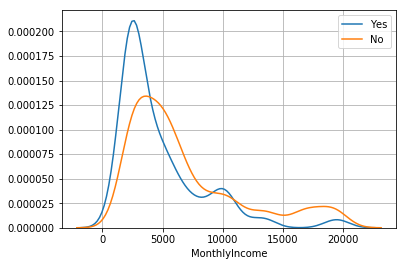

In [391]:
DensityPlots('MonthlyIncome')

* Employees who quit have lower monthly income;
* The correlation between Monthly income and attrition is negative means employees with higher income have the lower possibility to leave.

#### Daily rate

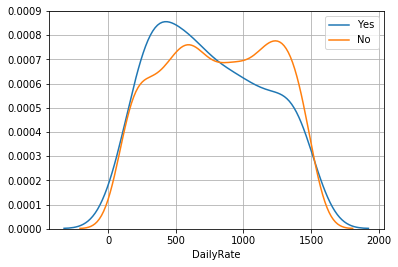

In [392]:
DensityPlots('DailyRate')

* Employees with lower daily rate have higher possibility to leave the company.

#### Age

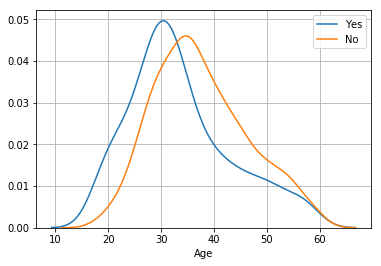

In [394]:
DensityPlots('Age')

* Employees whose age are younger than 30 have a higher possibility to quit.

#### Distance from home

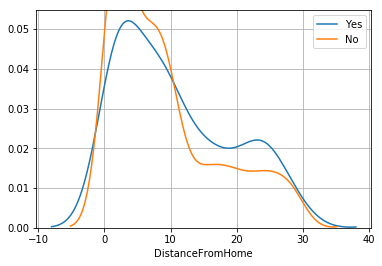

In [393]:
DensityPlots('DistanceFromHome')

* Employees work far away from home have a higher probability to leave.

#### Job role

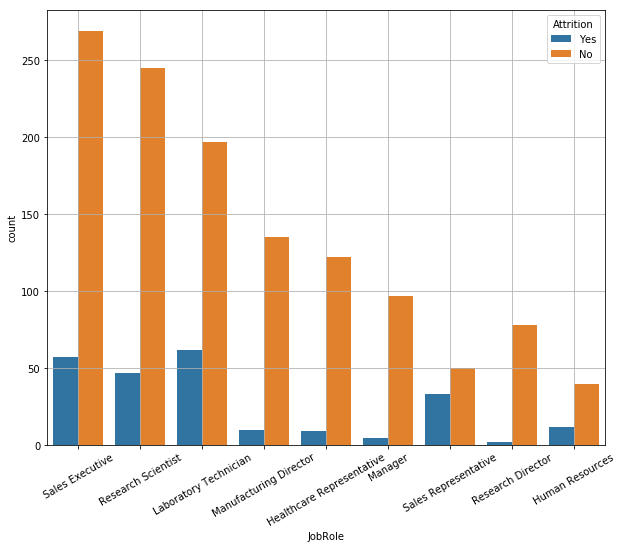

In [402]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot(x='JobRole', hue='Attrition', data=hr)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.grid(True)

* Employee trunover more usually happend in certainposition. For example, sales executive, research scientist, laboratory technician and sales representative.


#### Total work years

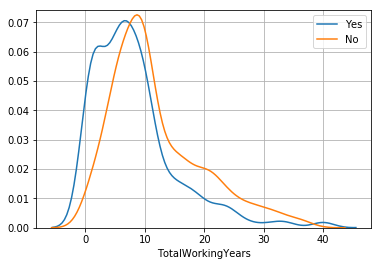

In [408]:
DensityPlots('TotalWorkingYears')

#### Percent Salary Hike

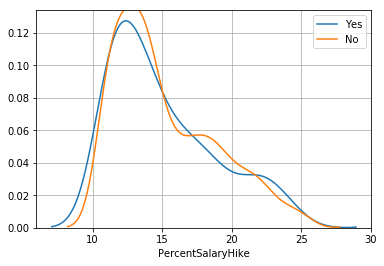

In [409]:
DensityPlots('PercentSalaryHike')

#### YearsWithCurrManager

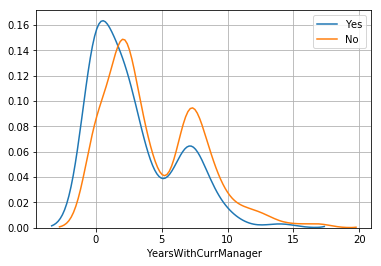

In [410]:
DensityPlots('YearsWithCurrManager')

#### Over time

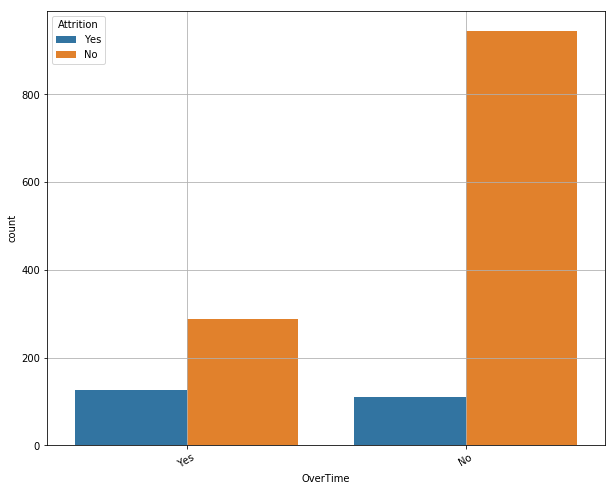

In [431]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot(x='OverTime', hue='Attrition', data=hr)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.grid(True)

* Employees who consider themselves worked over have very high probability to leave.

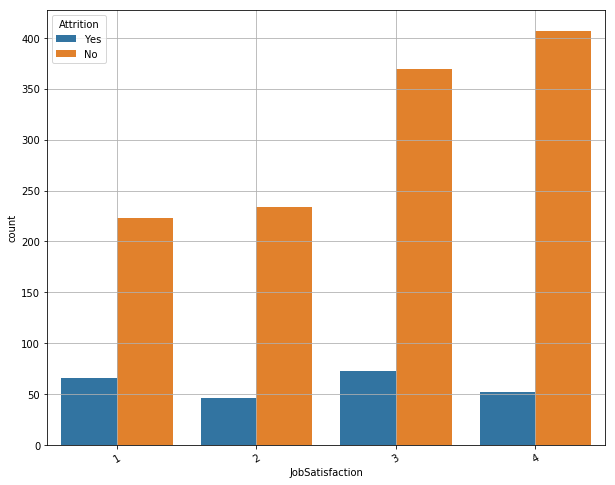

In [435]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot(x='JobSatisfaction', hue='Attrition', data=hr)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.grid(True)

#### Training Time Last Year

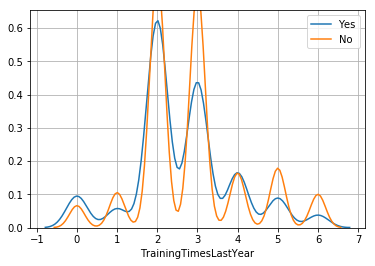

In [442]:
DensityPlots('TrainingTimesLastYear')

* Looks like employees want more taining time

### Job Satisfaction

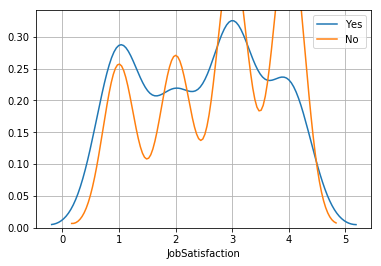

In [441]:
DensityPlots('JobSatisfaction')

### Interrelationship of certain variables about churn：

No handles with labels found to put in legend.
No handles with labels found to put in legend.


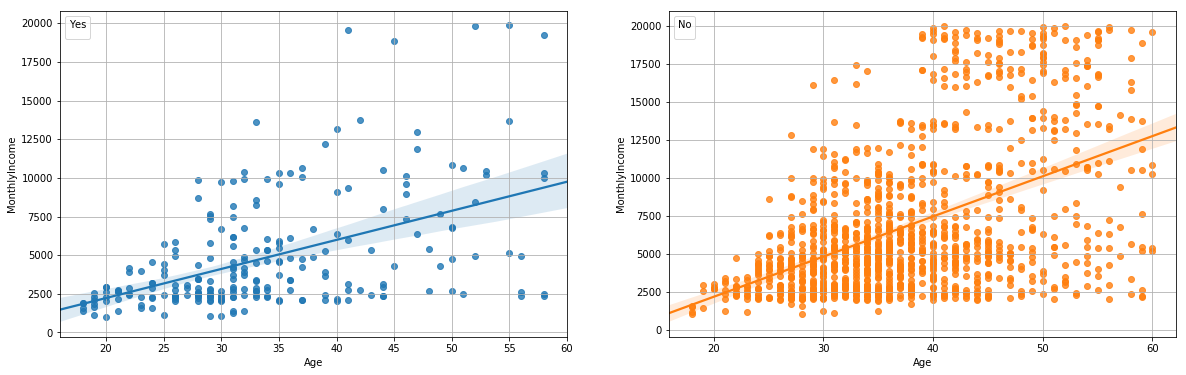

In [428]:
fig, ax =plt.subplots(1, 2, figsize=(20,6))
ax[0]=plt.subplot2grid((1,2),(0,0))
ax[1]=plt.subplot2grid((1,2),(0,1))
sns.regplot(x='Age', y='MonthlyIncome', data=hr[hr['Attrition']=='Yes'], ax=ax[0])
sns.regplot(x='Age', y='MonthlyIncome', data=hr[hr['Attrition']!='Yes'], ax=ax[1])
ax[0].legend(title = 'Yes')
ax[1].legend(title = 'No')
ax[0].grid(True)
ax[1].grid(True)

* Employees whom turnover have lower monthly income compared with colleagues of similar ages.